# Processing NASA Satellite HDF5 Files

This notebook will help you:
1. Explore the structure of .h5 files
2. Extract satellite data
3. Generate images from individual files
4. Create composite images from multiple files (monthly aggregates)

These appear to be VIIRS (Visible Infrared Imaging Radiometer Suite) data from NASA EarthData.

## 1. Install Required Packages

Run this cell first to install necessary packages if you don't have them:

In [1]:
# Uncomment and run if you need to install packages
# !pip install h5py numpy matplotlib cartopy pillow

## 2. Import Libraries

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
%matplotlib inline

## 3. Set Your Data Directory

Update this path to point to your folder containing the .h5 files:

In [3]:
# UPDATE THIS PATH to your data folder
data_dir = "/Users/dazedinthecity/Desktop/Data_sci_proj/nightlights/test_in_tut_0402_monthly"

# Create output directory for images
output_dir = "output_images_ikea_0302"
os.makedirs(output_dir, exist_ok=True)

# Get list of all .h5 files
h5_files = sorted(glob.glob(os.path.join(data_dir, "*.h5")))
print(f"Found {len(h5_files)} HDF5 files")
if h5_files:
    print(f"First file: {os.path.basename(h5_files[0])}")
    print(f"Last file: {os.path.basename(h5_files[-1])}")

Found 2 HDF5 files
First file: VNP46A3.A2014182.h19v04.002.2025090185911.h5
Last file: VNP46A3.A2014213.h19v04.002.2025090190652.h5


## 4. Explore File Structure

Let's look at what's inside one of your .h5 files:

In [4]:
def explore_h5_structure(filepath, max_depth=3):
    """
    Explore the structure of an HDF5 file.
    """
    print(f"\n{'='*70}")
    print(f"File: {os.path.basename(filepath)}")
    print(f"Size: {os.path.getsize(filepath) / (1024*1024):.1f} MB")
    print(f"{'='*70}\n")
    
    datasets_found = []
    
    with h5py.File(filepath, 'r') as f:
        def print_structure(name, obj, depth=0):
            indent = "  " * depth
            if isinstance(obj, h5py.Dataset):
                print(f"{indent}📊 Dataset: {name}")
                print(f"{indent}   Shape: {obj.shape}, Dtype: {obj.dtype}")
                if len(obj.shape) >= 2:  # 2D or higher dimensional data
                    datasets_found.append(name)
                # Show some attributes
                if obj.attrs:
                    attrs = list(obj.attrs.keys())[:3]
                    print(f"{indent}   Attributes: {', '.join(attrs)}...")
            elif isinstance(obj, h5py.Group):
                print(f"{indent}📁 Group: {name}")
        
        # Print groups and datasets
        for key in f.keys():
            print_structure(key, f[key], 0)
            if isinstance(f[key], h5py.Group):
                for subkey in f[key].keys():
                    print_structure(f"{key}/{subkey}", f[key][subkey], 1)
                    if isinstance(f[key][subkey], h5py.Group) and max_depth > 2:
                        for subsubkey in f[key][subkey].keys():
                            print_structure(f"{key}/{subkey}/{subsubkey}", 
                                          f[key][subkey][subsubkey], 2)
    
    return datasets_found

# Explore the first file
if h5_files:
    datasets = explore_h5_structure(h5_files[0])
    print(f"\n\n🎯 Found {len(datasets)} datasets with 2D+ data")


File: VNP46A3.A2014182.h19v04.002.2025090185911.h5
Size: 97.0 MB

📁 Group: HDFEOS
  📁 Group: HDFEOS/ADDITIONAL
    📁 Group: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
  📁 Group: HDFEOS/GRIDS
    📁 Group: HDFEOS/GRIDS/VIIRS_Grid_DNB_2d
📁 Group: HDFEOS INFORMATION
  📊 Dataset: HDFEOS INFORMATION/StructMetadata.0
     Shape: (), Dtype: |S32000


🎯 Found 0 datasets with 2D+ data


## 5. Function to Extract and Plot Data

This function will read data from the .h5 file and create an image:

In [5]:
def extract_and_plot_dataset(filepath, dataset_path, output_path=None, 
                            cmap='viridis', vmin=None, vmax=None, title=None):
    """
    Extract a dataset from HDF5 file and create an image.
    
    Parameters:
    -----------
    filepath : str
        Path to the .h5 file
    dataset_path : str
        Path to the dataset within HDF5 (e.g., 'HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance')
    output_path : str, optional
        Where to save the image. If None, just displays it.
    cmap : str
        Matplotlib colormap name
    vmin, vmax : float, optional
        Min and max values for color scaling
    title : str, optional
        Plot title
    """
    
    with h5py.File(filepath, 'r') as f:
        # Check if dataset exists
        if dataset_path not in f:
            print(f"Dataset '{dataset_path}' not found!")
            return None
        
        # Read the dataset
        data = f[dataset_path][:]
        
        # Handle attributes (scale factor, offset, fill values)
        attrs = f[dataset_path].attrs
        
        # Apply scale factor if available
        if 'Scale' in attrs or 'scale_factor' in attrs:
            scale = attrs.get('Scale', attrs.get('scale_factor', 1.0))
            data = data.astype(float) * scale
        
        # Apply offset if available
        if 'Offset' in attrs or 'add_offset' in attrs:
            offset = attrs.get('Offset', attrs.get('add_offset', 0.0))
            data = data + offset
        
        # Mask fill values
        fill_value = attrs.get('_FillValue', attrs.get('FillValue', None))
        if fill_value is not None:
            data = np.ma.masked_equal(data, fill_value)
        
        # Also mask extreme values that might be invalid
        data = np.ma.masked_invalid(data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot the data
    im = ax.imshow(data, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Value', rotation=270, labelpad=20)
    
    # Set title
    if title is None:
        title = f"{os.path.basename(filepath)}\n{dataset_path}"
    ax.set_title(title, fontsize=12, pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add data statistics
    stats_text = f"Min: {np.ma.min(data):.3e}\nMax: {np.ma.max(data):.3e}\nMean: {np.ma.mean(data):.3e}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    plt.show()
    
    return data

## 6. Find Available Datasets

Let's find all datasets that contain image data:

In [6]:
def find_image_datasets(filepath):
    """
    Find all datasets in an HDF5 file that could be images (2D or 3D arrays).
    """
    image_datasets = []
    
    with h5py.File(filepath, 'r') as f:
        def find_datasets(name, obj):
            if isinstance(obj, h5py.Dataset):
                # Look for 2D or 3D datasets
                if len(obj.shape) >= 2 and obj.shape[0] > 1 and obj.shape[1] > 1:
                    image_datasets.append({
                        'path': name,
                        'shape': obj.shape,
                        'dtype': obj.dtype,
                        'size_mb': obj.size * obj.dtype.itemsize / (1024*1024)
                    })
        
        f.visititems(find_datasets)
    
    return image_datasets

# Find datasets in the first file
if h5_files:
    image_datasets = find_image_datasets(h5_files[0])
    print(f"Found {len(image_datasets)} potential image datasets:\n")
    for i, ds in enumerate(image_datasets, 1):
        print(f"{i}. {ds['path']}")
        print(f"   Shape: {ds['shape']}, Size: {ds['size_mb']:.2f} MB\n")

Found 26 potential image datasets:

1. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered
   Shape: (2400, 2400), Size: 21.97 MB

2. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered_Num
   Shape: (2400, 2400), Size: 10.99 MB

3. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered_Quality
   Shape: (2400, 2400), Size: 5.49 MB

4. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered_Std
   Shape: (2400, 2400), Size: 21.97 MB

5. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free
   Shape: (2400, 2400), Size: 21.97 MB

6. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free_Num
   Shape: (2400, 2400), Size: 10.99 MB

7. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free_Quality
   Shape: (2400, 2400), Size: 5.49 MB

8. HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free_Std
   Shape: (2400, 2400), Size: 21.97 MB

9.

## 7. Plot a Single Image

Now let's create an image from one file. Update the `dataset_path` based on the output above:

Saved: output_images_ikea_0302/single_image_VNP46A3.A2014182.h19v04.002.2025090185911.h5.png


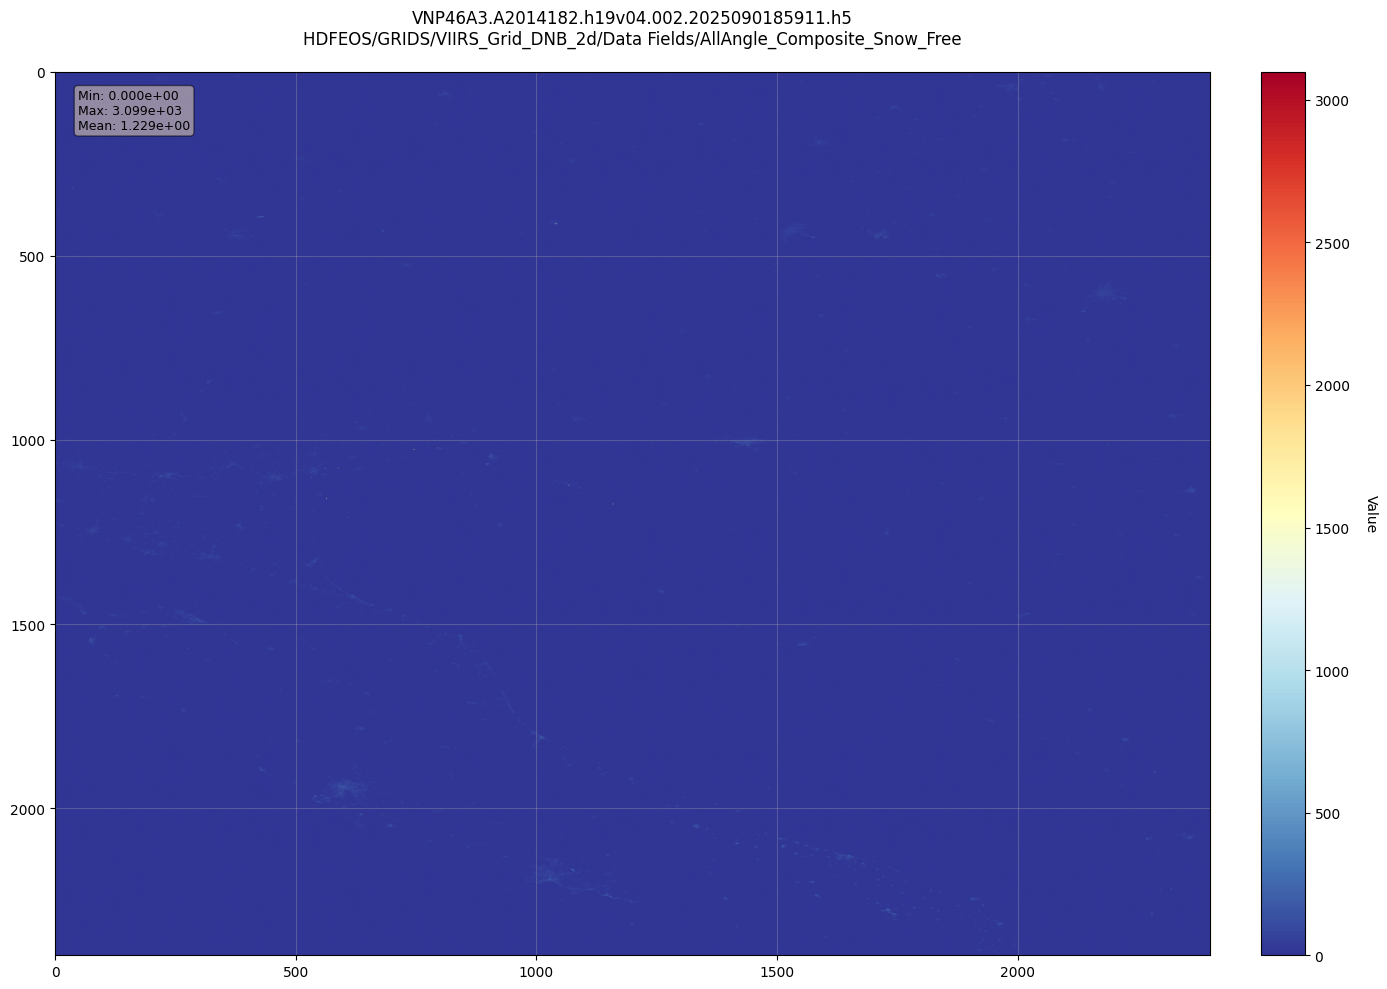

In [7]:
# UPDATE THIS: Choose the dataset path from the list above
# Common VIIRS dataset paths:
# - For DNB (Day-Night Band): 'HDFEOS/GRIDS/VNP_Grid_DNB/Data Fields/DNB_At_Sensor_Radiance'
# - For other bands: Look for paths containing 'Radiance' or 'Reflectance'

dataset_path = 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free'  # Example - update this!

if h5_files:
    # Process first file
    output_file = os.path.join(output_dir, f"single_image_{os.path.basename(h5_files[0])}.png")
    data = extract_and_plot_dataset(
        h5_files[0], 
        dataset_path,
        output_path=output_file,
        cmap='RdYlBu_r'  # Try 'viridis', 'plasma', 'gray', 'RdYlBu_r'
    )

## 8. Process All Files in the Folder

Generate images from all .h5 files:

Processing 2 files...

[1/2] Processing: VNP46A3.A2014182.h19v04.002.2025090185911.h5
Saved: output_images_ikea_0302/VNP46A3.A2014182.h19v04.002.2025090185911.png


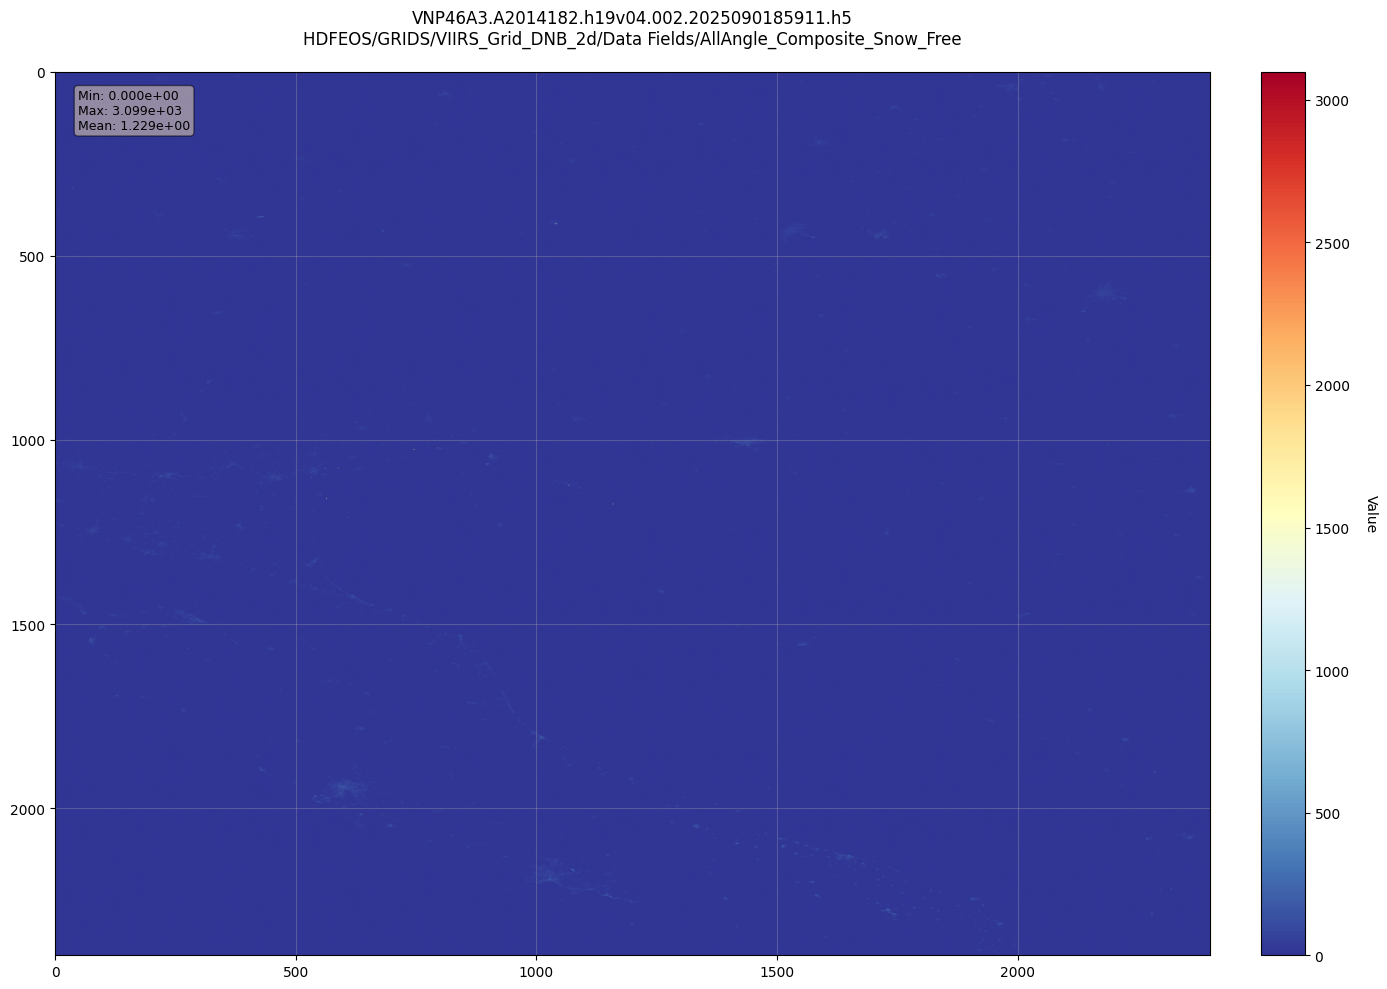

[2/2] Processing: VNP46A3.A2014213.h19v04.002.2025090190652.h5
Saved: output_images_ikea_0302/VNP46A3.A2014213.h19v04.002.2025090190652.png


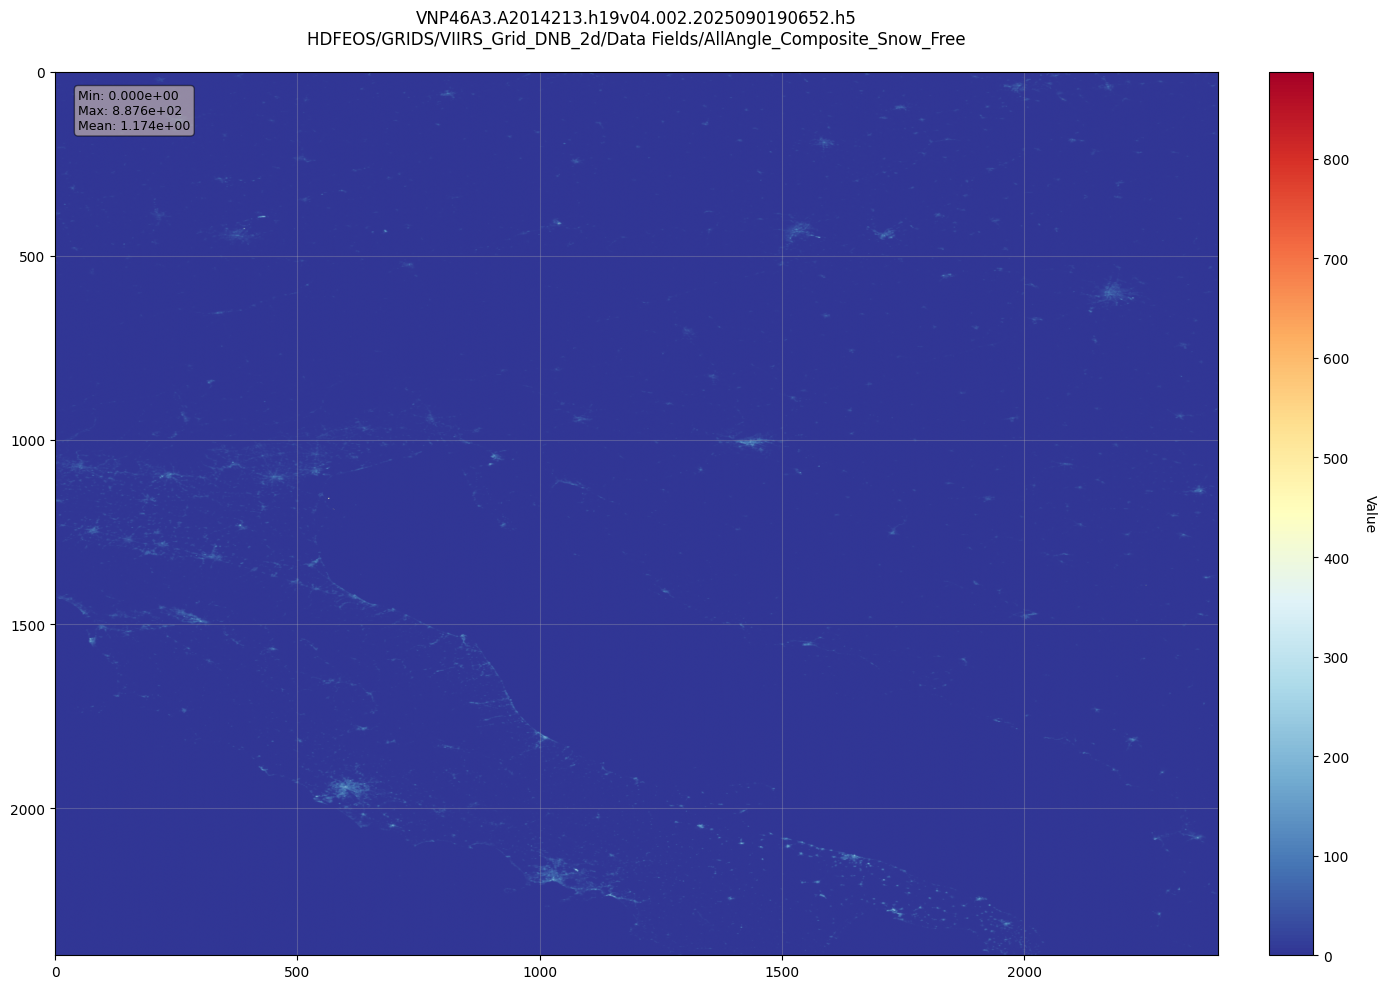


✅ Done! Images saved to: output_images_ikea_0302


In [ ]:
def process_all_files(file_list, dataset_path, output_folder, cmap='RdYlBu_r', 
                     max_files=None, show_progress=True):
    """
    Process multiple HDF5 files and generate images.
    
    Parameters:
    -----------
    file_list : list
        List of file paths
    dataset_path : str
        Path to dataset within each file
    output_folder : str
        Where to save images
    cmap : str
        Colormap to use
    max_files : int, optional
        Maximum number of files to process (None for all)
    show_progress : bool
        Whether to show progress
    """
    os.makedirs(output_folder, exist_ok=True)
    
    files_to_process = file_list[:max_files] if max_files else file_list
    
    print(f"Processing {len(files_to_process)} files...\n")
    
    for i, filepath in enumerate(files_to_process, 1):
        if show_progress:
            print(f"[{i}/{len(files_to_process)}] Processing: {os.path.basename(filepath)}")
        
        # Generate output filename
        base_name = os.path.splitext(os.path.basename(filepath))[0]
        output_path = os.path.join(output_folder, f"{base_name}.png")
        
        try:
            # Extract and save (without displaying)
            plt.ioff()  # Turn off interactive mode
            extract_and_plot_dataset(
                filepath,
                dataset_path,
                output_path=output_path,
                cmap=cmap
            )
            plt.close('all')  # Close figures to save memory
            
        except Exception as e:
            print(f"  ⚠️  Error processing {os.path.basename(filepath)}: {str(e)}")
    
    plt.ion()  # Turn interactive mode back on
    print(f"\n✅ Done! Images saved to: {output_folder}")

# Process all files (or set max_files to process only a few for testing)
if h5_files and dataset_path:
    process_all_files(
        h5_files, 
        dataset_path, 
        output_dir,
        cmap='RdYlBu_r',
        max_files=None  # Set to 5 for testing, None for all files
    )

## 9. Create Monthly Composite Image

Combine all files to create an average/composite image for the month:

Creating mean composite from 8 files...
Computing mean composite...

✅ Composite saved to: output_images_ikea_0302/monthly_composite_mean.png


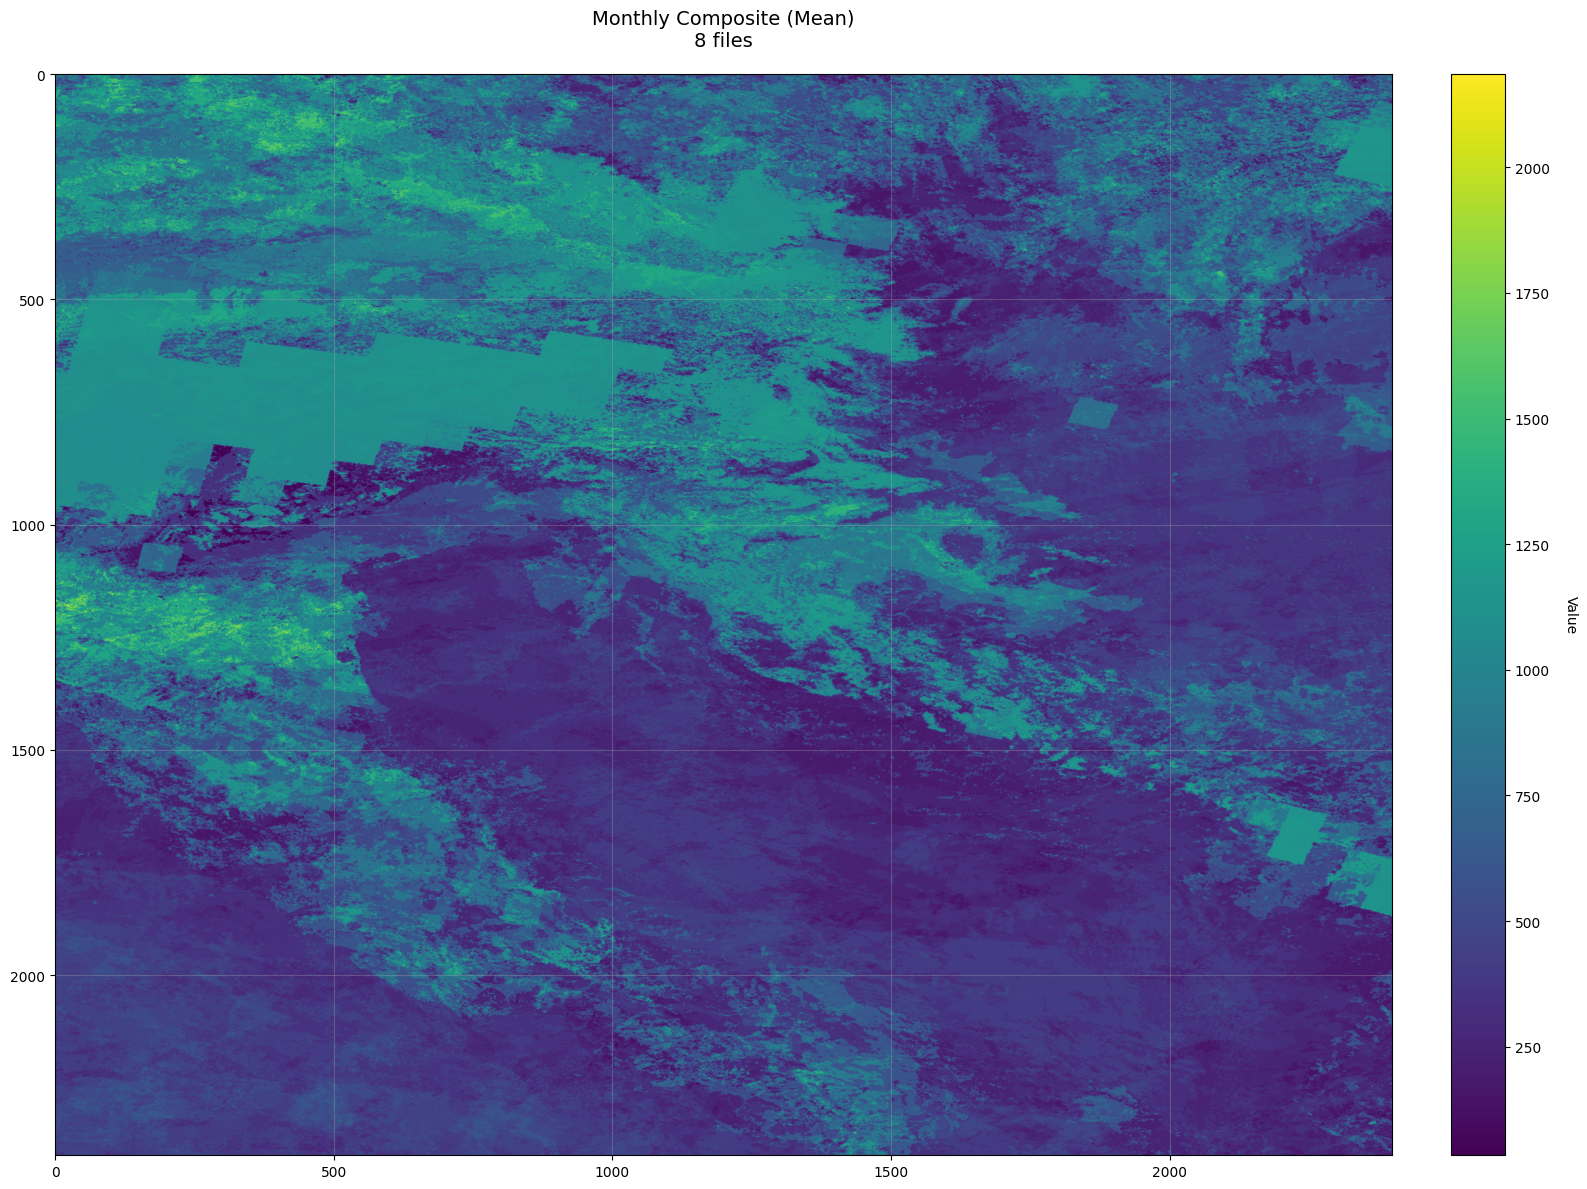

In [30]:
def create_monthly_composite(file_list, dataset_path, output_path, 
                            method='mean', cmap='gray'):
    """
    Create a composite image from multiple HDF5 files.
    
    Parameters:
    -----------
    file_list : list
        List of HDF5 file paths
    dataset_path : str
        Path to dataset within files
    output_path : str
        Where to save the composite image
    method : str
        'mean', 'median', 'max', or 'min'
    cmap : str
        Colormap
    """
    print(f"Creating {method} composite from {len(file_list)} files...")
    
    all_data = []
    
    for i, filepath in enumerate(file_list, 1):
        if i % 10 == 0:
            print(f"  Loading file {i}/{len(file_list)}...")
        
        try:
            with h5py.File(filepath, 'r') as f:
                if dataset_path not in f:
                    continue
                    
                data = f[dataset_path][:]
                attrs = f[dataset_path].attrs
                
                # Apply scaling
                if 'Scale' in attrs or 'scale_factor' in attrs:
                    scale = attrs.get('Scale', attrs.get('scale_factor', 1.0))
                    data = data.astype(float) * scale
                
                if 'Offset' in attrs or 'add_offset' in attrs:
                    offset = attrs.get('Offset', attrs.get('add_offset', 0.0))
                    data = data + offset
                
                # Mask invalid values
                fill_value = attrs.get('_FillValue', attrs.get('FillValue', None))
                if fill_value is not None:
                    data = np.ma.masked_equal(data, fill_value)
                
                data = np.ma.masked_invalid(data)
                all_data.append(data)
                
        except Exception as e:
            print(f"  Warning: Could not read {os.path.basename(filepath)}: {e}")
    
    if not all_data:
        print("No valid data found!")
        return None
    
    print(f"Computing {method} composite...")
    
    # Stack all data
    stacked = np.ma.stack(all_data)
    
    # Compute composite
    if method == 'mean':
        composite = np.ma.mean(stacked, axis=0)
    elif method == 'median':
        composite = np.ma.median(stacked, axis=0)
    elif method == 'max':
        composite = np.ma.max(stacked, axis=0)
    elif method == 'min':
        composite = np.ma.min(stacked, axis=0)
    else:
        composite = np.ma.mean(stacked, axis=0)
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 12))
    im = ax.imshow(composite, cmap=cmap, aspect='auto')
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Value', rotation=270, labelpad=20)
    
    ax.set_title(f'Monthly Composite ({method.capitalize()})\n{len(file_list)} files', 
                fontsize=14, pad=20)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Composite saved to: {output_path}")
    plt.show()
    
    return composite

# Create monthly composite
if h5_files and dataset_path:
    composite_path = os.path.join(output_dir, "monthly_composite_mean.png")
    composite = create_monthly_composite(
        h5_files,
        dataset_path,
        composite_path,
        method='mean',  # Try 'mean', 'median', 'max', or 'min'
        cmap='viridis'
    )

## 10. Alternative: Try Different Colormaps

Compare different visualization styles:

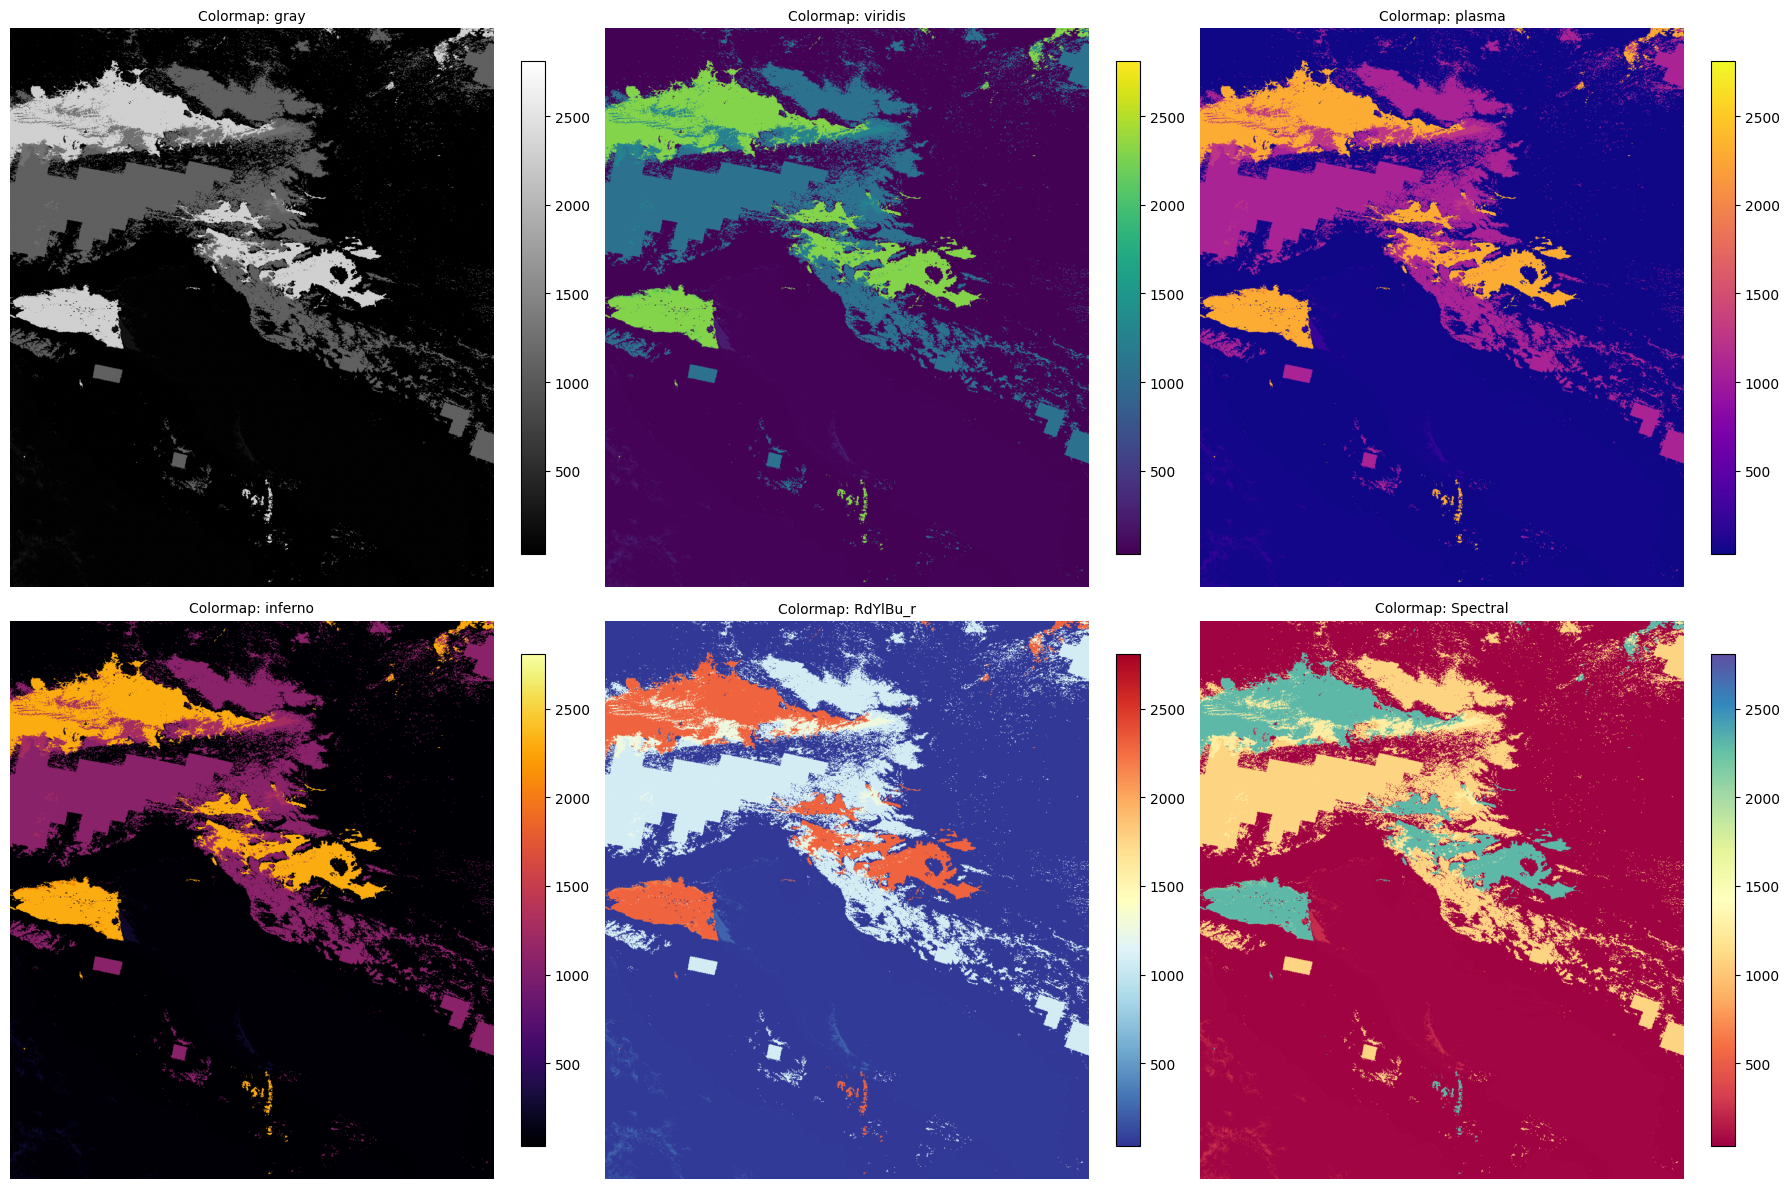

In [31]:
# Try different colormaps on the same file
if h5_files and dataset_path:
    colormaps = ['gray', 'viridis', 'plasma', 'inferno', 'RdYlBu_r', 'Spectral']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    with h5py.File(h5_files[0], 'r') as f:
        data = f[dataset_path][:]
        attrs = f[dataset_path].attrs
        
        # Apply scaling
        if 'Scale' in attrs or 'scale_factor' in attrs:
            scale = attrs.get('Scale', attrs.get('scale_factor', 1.0))
            data = data.astype(float) * scale
        
        fill_value = attrs.get('_FillValue', attrs.get('FillValue', None))
        if fill_value is not None:
            data = np.ma.masked_equal(data, fill_value)
    
    for ax, cmap in zip(axes, colormaps):
        im = ax.imshow(data, cmap=cmap, aspect='auto')
        ax.set_title(f'Colormap: {cmap}', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'colormap_comparison.png'), dpi=150)
    plt.show()

## 11. Summary

Run this cell to see a summary of what was created:

In [15]:
# Count output images
output_images = glob.glob(os.path.join(output_dir, "*.png"))
print(f"\n{'='*70}")
print(f"SUMMARY")
print(f"{'='*70}")
print(f"Input HDF5 files: {len(h5_files)}")
print(f"Output images created: {len(output_images)}")
print(f"Output directory: {os.path.abspath(output_dir)}")
print(f"{'='*70}")


SUMMARY
Input HDF5 files: 175
Output images created: 178
Output directory: /Users/dazedinthecity/Desktop/Data_sci_proj/output_images


In [ ]:
/Users/dazedinthecity/Desktop/Data_sci_proj/nightlights/VNP46A2_2-20260203_140713